In [1]:
# NN packages
import jax
import jax.numpy as jnp
import optax

# Visualization packages
import matplotlib.pyplot as plt

# ML Models
from models.MDOF_LNN import Physical_Damped_LNN, Modal_MLP

# Helper functions
from helpers import save_to_file, create_modal_training_data, plot_S_curves, plot_3DS_curves

#### Data Extraction
In this section, we extract the `pose`, `velocity`, `acceleration`, `time`, `force amplitude` and `period` from each continuation simulation file. This dataset was created for **frequencies** ranging from $10.0Hz$ to $24.0Hz$ in steps of $0.2Hz$, where for each, the continuation parameter was the **forcing amplitude**.

The output is in **modal coordinates**.

In [2]:
filename='frequency_step_frequency_'
path='results/modal'
start=10.0
stop=24.0
step=0.2

ml_data = save_to_file(filename=filename, path=path, start=start, stop=stop, step=step, check=True)

Data saved to results/modal/data.pkl
Number of files: 71

---EXAMPLE SHAPES---
pose: (2, 301, 39), vel: (2, 301, 39), acc: (2, 301, 39)
If MODAL: 2 Modes, 301 time steps per 39 points along curve
If PHYSICAL: 301 time steps per 39 points along curve
time: (301, 39), F: (39,), T: (39,), force: (2, 301, 39)


#### Dataset Visualization

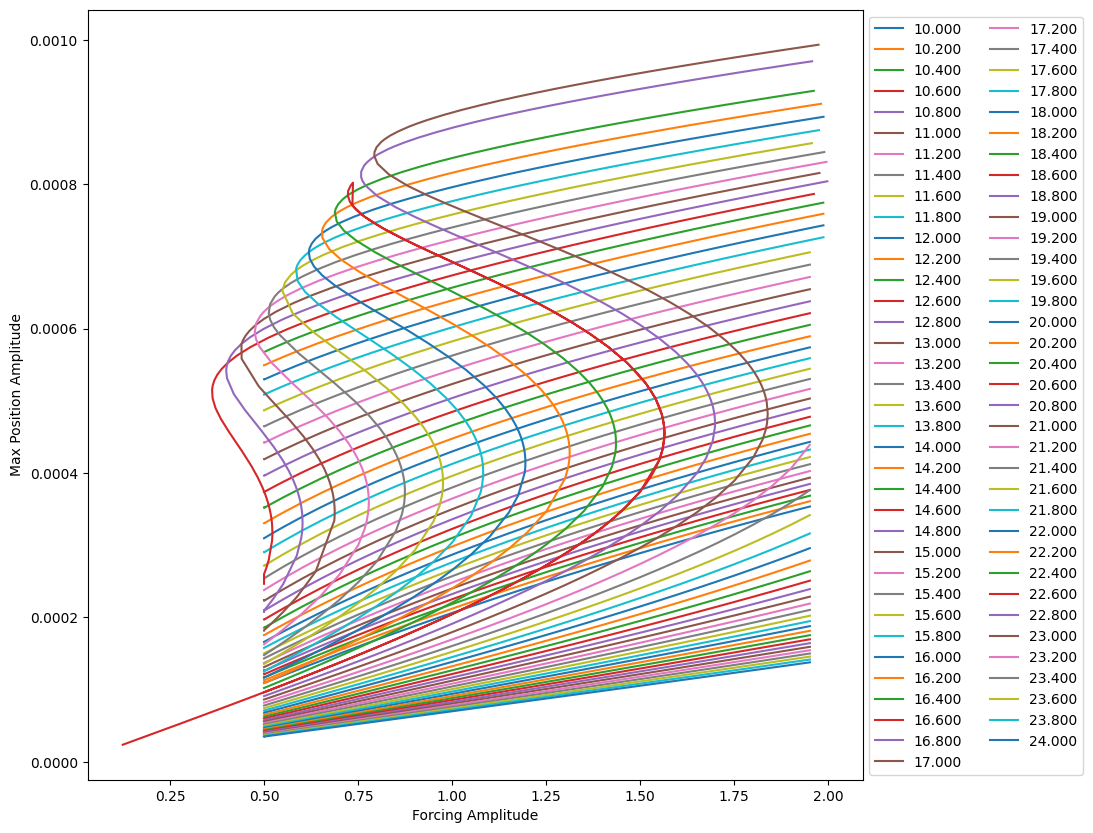

In [3]:
plot_S_curves(ml_data)

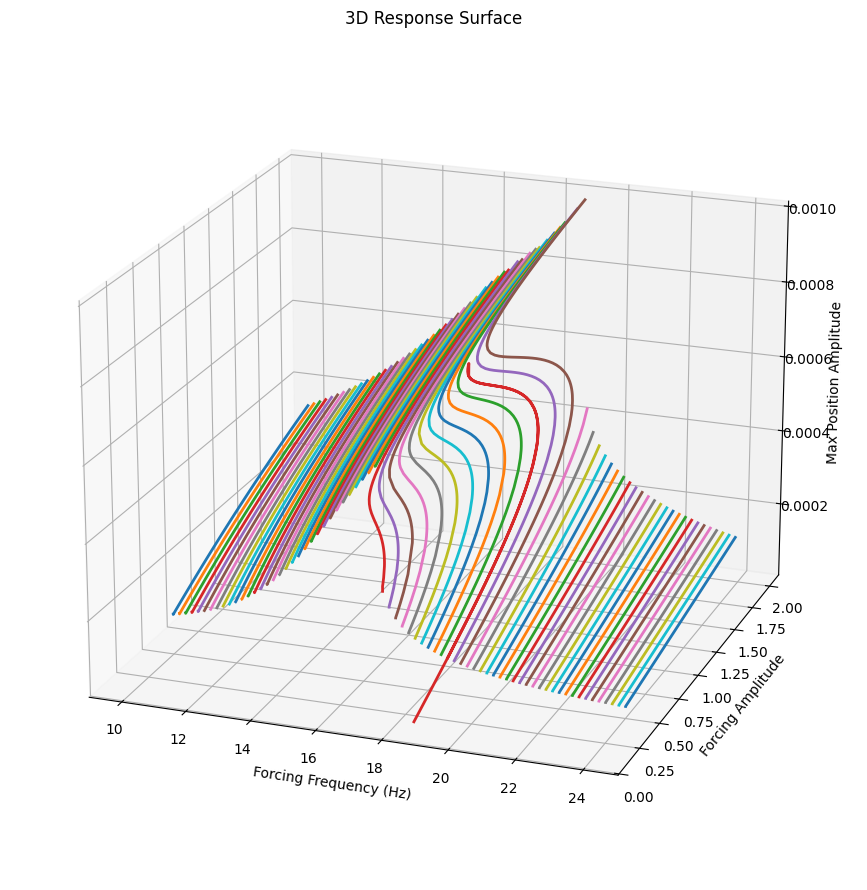

In [4]:
plot_3DS_curves(ml_data)

#### LNN Dataset Formation

In [5]:
train_data, test_data, info = create_modal_training_data(ml_data, path, split=0.2, seed=42)

Training data shape: (805175, 2, 4), Testing data shape: (207389, 2, 4)
Samples, # of Modes, [x, dx, ddx, force]
x_train.shape: (805175, 2), dx_train.shape: (805175, 2), ddx_train.shape: (805175, 2), force_train.shape: (805175, 2)
x_test.shape: (207389, 2), dx_test.shape: (207389, 2), ddx_test.shape: (207389, 2), force_test.shape: (207389, 2)


In [6]:
# Format dataset for LNN
# Position, velocity & total forcing conditions
train_x = train_data[:, :, :2]
train_dx = train_data[:, :, 1:3]
train_f = train_data[:, :, 3:]

test_x = test_data[:, :, :2]
test_dx = test_data[:, :, 1:3]
test_f = test_data[:, :, 3:]

train_data = train_x, train_f, train_dx
test_data = test_x, test_f, test_dx

In [7]:
train_data[0].shape, test_data[0].shape, train_data[1].shape, test_data[1].shape, train_data[2].shape, test_data[2].shape

((805175, 2, 2),
 (207389, 2, 2),
 (805175, 2, 1),
 (207389, 2, 1),
 (805175, 2, 2),
 (207389, 2, 2))

In [8]:
# __x = train_data[0][:, :, 0]
# __dx = train_data[0][:, :, 1]
# __ddx = train_data[2][:, :, 1]
# __force = train_data[1][:, :, 0]
# __x.shape, __dx.shape, __ddx.shape, __force.shape

In [9]:
# # Beam paremeters for 2 mode system
# k_nl = 4250000
# w_1 = 91.734505484821950
# w_2 = 3.066194429903638e02
# zeta_1 = 0.03
# zeta_2 = 0.09
# phi_L = np.array([[-7.382136522799137, 7.360826867549465]])

# # Modal Matrices
# M = np.eye(2)
# C = np.array([[2 * zeta_1 * w_1, 0], [0, 2 * zeta_2 * w_2]])
# K = np.array([[w_1**2, 0], [0, w_2**2]])
# Minv = spl.inv(M)

# # Calculate acceleration
# calc_acc = Minv @ (-K @ __x.swapaxes(0, 1) - C @ __dx.swapaxes(0, 1) - k_nl * phi_L.T @ ((phi_L @ __x.swapaxes(0, 1))**3) + __force.swapaxes(0, 1))

In [10]:
# M.shape, K.shape, C.shape, Minv.shape, __x.shape, __dx.shape, __force.shape, calc_acc.shape

#### LNN


In [11]:
mnn_settings = {
    'name': 'MNN',
    'units': 16,
    'layers': 2,
    'input_shape': 2,
    'train_batch_size': 128,
    'test_batch_size': 64,
    'shuffle': True,
    'seed': 69
    }

knn_settings = {
    'name': 'KNN',
    'units': 16,
    'layers': 2,
    'input_shape': 2,
    }

dnn_settings = {
    'name': 'DNN',
    'units': 16,
    'layers': 2,
    'input_shape': 2,
    }

results_path = 'MDOF_LNN'
file_name='Phys'

lr = 1e-03
mnn_optimizer = optax.adam(lr)
knn_optimizer = optax.adam(lr)
dnn_optimizer = optax.adam(lr)
epochs = 20
show_every = 10

In [12]:
a = Physical_Damped_LNN(
    mnn_module=Modal_MLP, 
    knn_module=Modal_MLP,       
    dnn_module=Modal_MLP, 
    mnn_settings=mnn_settings,
    knn_settings=knn_settings,
    dnn_settings=dnn_settings, 
    mnn_optimizer=mnn_optimizer, 
    knn_optimizer=knn_optimizer, 
    dnn_optimizer=dnn_optimizer, 
    info=info, 
    activation=jax.nn.tanh)

# Start training LNN
results = None
_, _, _ = a.gather()

In [13]:
results_path = 'MDOF_LNN'
file_name='Modal'

epochs = 20
show_every = 10

In [14]:
# Standard loss
for _ in range(10):
    results = a.train(train_data, test_data, results, epochs=epochs, show_every=show_every)
    a.save_model(results, model_name=f"Iter_{results['last_epoch']}", folder_name=f"{results_path}/{file_name}")
print(f"Final loss: {results['best_loss']}")

Epoch: 0 | Train Loss: 464152.68750000 | Best Loss: 3237.62182617 | Test Loss: 3237.62182617
---------------------------------
Epoch: 10 | Train Loss: 0.06152350 | Best Loss: 0.09221186 | Test Loss: 0.09221186
---------------------------------
Epoch: 20 | Train Loss: 0.00005944 | Best Loss: 0.00009326 | Test Loss: 0.00009811
---------------------------------
Epoch: 30 | Train Loss: 0.00001951 | Best Loss: 0.00001230 | Test Loss: 0.00001230
---------------------------------
Epoch: 40 | Train Loss: 0.00000991 | Best Loss: 0.00001128 | Test Loss: 0.00001128
---------------------------------
Epoch: 50 | Train Loss: 0.00000782 | Best Loss: 0.00000570 | Test Loss: 0.00000961
---------------------------------
Epoch: 60 | Train Loss: 0.00000612 | Best Loss: 0.00000501 | Test Loss: 0.00000598
---------------------------------
Epoch: 70 | Train Loss: 0.00000559 | Best Loss: 0.00000357 | Test Loss: 0.00000357
---------------------------------
Epoch: 80 | Train Loss: 0.00000524 | Best Loss: 0.0000

In [15]:
_, pred_energy = a._predict(results)

In [16]:
limq1, limq2, limqd1, limqd2 = info["qmin"], info["qmax"], info["qdmax"], info["qdmin"]

qa, qda = jnp.linspace(limq1, limq2, 100), jnp.linspace(
    limqd1, limqd2, 100)
qaa, qdaa = jnp.meshgrid(qa, qda)
qa.shape, qda.shape, qaa.shape, qdaa.shape

((100,), (100,), (100, 100), (100, 100))

In [17]:
M, K, C = jax.vmap(pred_energy)(jnp.concatenate([qaa.reshape(-1, 1), qaa.reshape(-1, 1)], axis=1), jnp.concatenate([qdaa.reshape(-1, 1), qdaa.reshape(-1, 1)], axis=1))

L = M - K
M.shape, K.shape, C.shape, L.shape

((10000, 2), (10000, 2), (10000, 2), (10000, 2))

In [18]:
# Beam paremeters for 2 mode system
k_nl = 4250000
w_1 = 91.734505484821950
w_2 = 3.066194429903638e02
zeta_1 = 0.03
zeta_2 = 0.09
phi_L = jnp.array([[-7.382136522799137, 7.360826867549465]])

# Modal Matrices
_M = jnp.eye(2)
_C = jnp.array([[2 * zeta_1 * w_1, 0], [0, 2 * zeta_2 * w_2]])
_K = jnp.array([[w_1**2, 0], [0, w_2**2]])

M_anal = 0.5 * jax.vmap(jnp.dot, in_axes=(None, 0))(_M, jnp.concatenate([qdaa.reshape(-1, 1), qdaa.reshape(-1, 1)], axis=1)**2)

K_anal = 0.5 * jax.vmap(jnp.dot, in_axes=(None, 0))(_K, jnp.concatenate([qaa.reshape(-1, 1), qaa.reshape(-1, 1)], axis=1)**2) + 0.25 * k_nl * jax.vmap(jnp.dot, in_axes=(None, 0))(phi_L.T, (jax.vmap(jnp.dot, in_axes=(None, 0))(phi_L, jnp.concatenate([qaa.reshape(-1, 1), qaa.reshape(-1, 1)], axis=1)**4)))

C_anal = 0.5 * jax.vmap(jnp.dot, in_axes=(None, 0))(_C, jnp.concatenate([qdaa.reshape(-1, 1), qdaa.reshape(-1, 1)], axis=1)**2)

L_anal = M_anal - K_anal

M_anal.shape, K_anal.shape, C_anal.shape

((10000, 2), (10000, 2), (10000, 2))

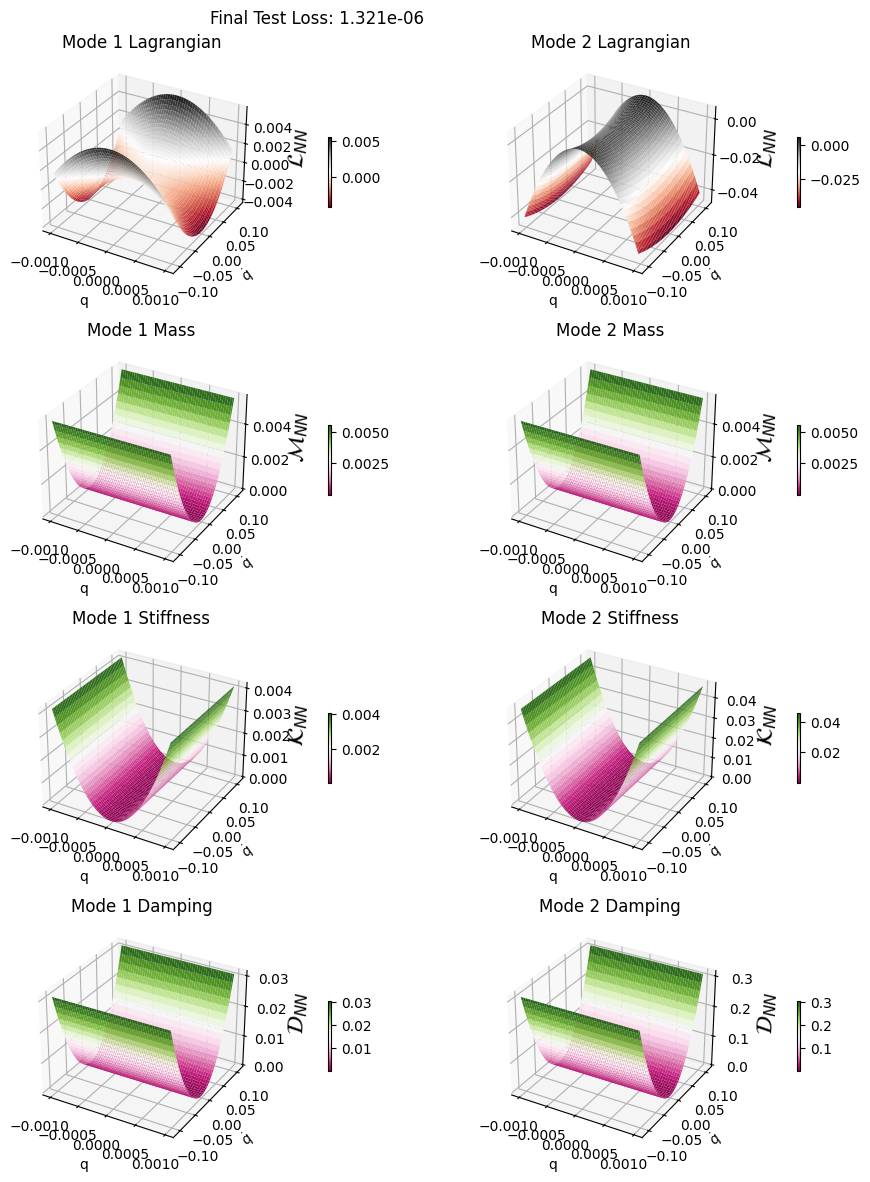

In [19]:
fig = plt.figure(figsize=(12, 12), tight_layout=True)
fig.suptitle(f"Final Test Loss: {results['best_loss']:.3e}")

# --------------------------------- FUNCTIONS

# -------------------------------- Lagrangian
ax = fig.add_subplot(421, projection="3d")
m = ax.plot_surface(qaa, qdaa, L_anal[:, 0].reshape(qaa.shape), cmap="RdGy", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{L}_{NN}$", fontsize=16, labelpad=3)
ax.set_title(f"Mode 1 Lagrangian")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

ax = fig.add_subplot(422, projection="3d")
m = ax.plot_surface(qaa, qdaa, L_anal[:, 1].reshape(qaa.shape), cmap="RdGy", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{L}_{NN}$", fontsize=16, labelpad=3)
ax.set_title(f"Mode 2 Lagrangian")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

# ---------------------------------- Mass
ax = fig.add_subplot(423, projection="3d")
m = ax.plot_surface(qaa, qdaa, M_anal[:, 0].reshape(qaa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{M}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 1 Mass")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

ax = fig.add_subplot(424, projection="3d")
m = ax.plot_surface(qaa, qdaa, M_anal[:, 1].reshape(qaa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{M}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 2 Mass")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

# ---------------------------------- Stiffness
ax = fig.add_subplot(425, projection="3d")
m = ax.plot_surface(qaa, qdaa, K_anal[:, 0].reshape(qaa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{K}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 1 Stiffness")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

ax = fig.add_subplot(426, projection="3d")
m = ax.plot_surface(qaa, qdaa, K_anal[:, 1].reshape(qaa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{K}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 2 Stiffness")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

# ---------------------------------- Damping
ax = fig.add_subplot(427, projection="3d")
m = ax.plot_surface(qaa, qdaa, C_anal[:, 0].reshape(qaa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{D}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 1 Damping")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

ax = fig.add_subplot(428, projection="3d")
m = ax.plot_surface(qaa, qdaa, C_anal[:, 1].reshape(qaa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{D}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 2 Damping")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)
# fig.savefig(f"./Modal_LNN/{file_name}-LD.png")


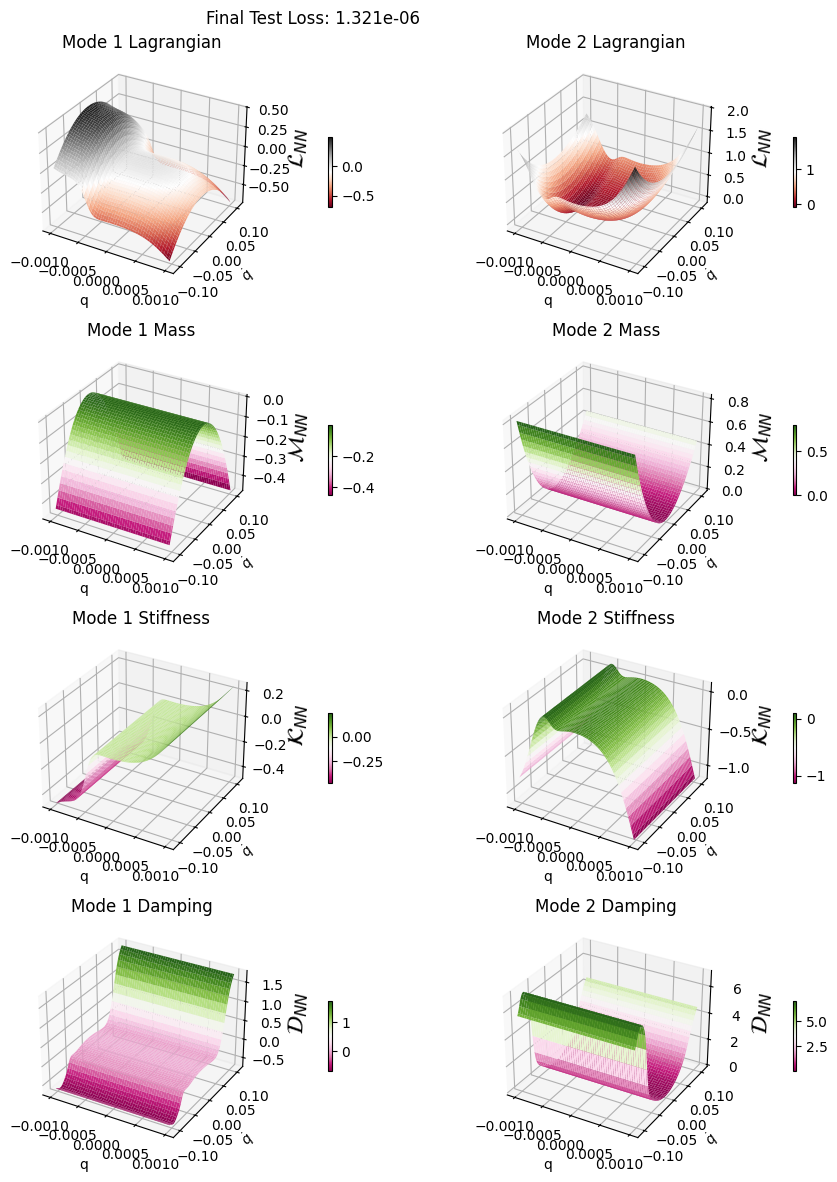

In [20]:
fig = plt.figure(figsize=(12, 12), tight_layout=True)
fig.suptitle(f"Final Test Loss: {results['best_loss']:.3e}")

# --------------------------------- FUNCTIONS

# -------------------------------- Lagrangian
ax = fig.add_subplot(421, projection="3d")
m = ax.plot_surface(qaa, qdaa, L[:, 0].reshape(qaa.shape), cmap="RdGy", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{L}_{NN}$", fontsize=16, labelpad=3)
ax.set_title(f"Mode 1 Lagrangian")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

ax = fig.add_subplot(422, projection="3d")
m = ax.plot_surface(qaa, qdaa, L[:, 1].reshape(qaa.shape), cmap="RdGy", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{L}_{NN}$", fontsize=16, labelpad=3)
ax.set_title(f"Mode 2 Lagrangian")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

# ---------------------------------- Mass
ax = fig.add_subplot(423, projection="3d")
m = ax.plot_surface(qaa, qdaa, M[:, 0].reshape(qaa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{M}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 1 Mass")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

ax = fig.add_subplot(424, projection="3d")
m = ax.plot_surface(qaa, qdaa, M[:, 1].reshape(qaa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{M}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 2 Mass")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

# ---------------------------------- Stiffness
ax = fig.add_subplot(425, projection="3d")
m = ax.plot_surface(qaa, qdaa, K[:, 0].reshape(qaa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{K}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 1 Stiffness")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

ax = fig.add_subplot(426, projection="3d")
m = ax.plot_surface(qaa, qdaa, K[:, 1].reshape(qaa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{K}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 2 Stiffness")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

# ---------------------------------- Damping
ax = fig.add_subplot(427, projection="3d")
m = ax.plot_surface(qaa, qdaa, C[:, 0].reshape(qaa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{D}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 1 Damping")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

ax = fig.add_subplot(428, projection="3d")
m = ax.plot_surface(qaa, qdaa, C[:, 1].reshape(qaa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{D}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 2 Damping")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)
# fig.savefig(f"./Modal_LNN/{file_name}-LD.png")


In [21]:
qa.shape, qda.shape, M.shape, K.shape, C.shape

((100,), (100,), (10000, 2), (10000, 2), (10000, 2))

Text(0.5, 1.0, 'Mass')

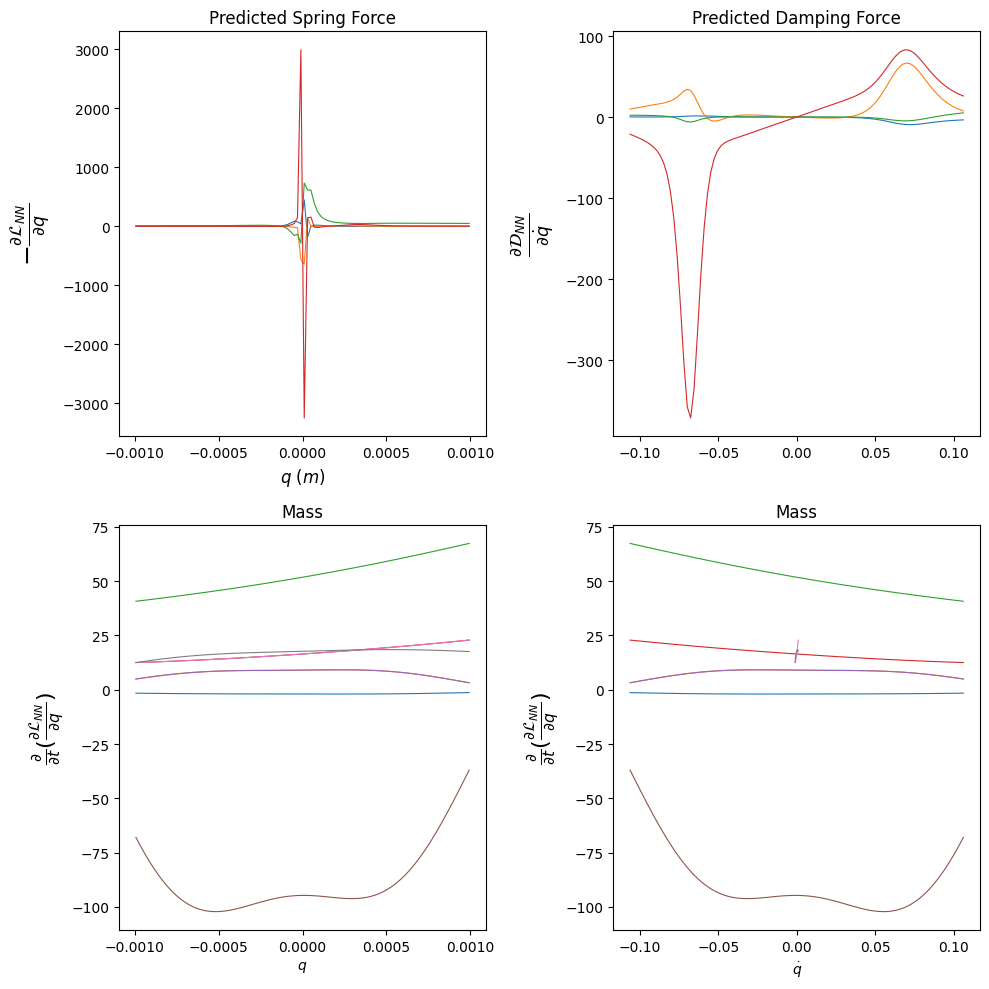

In [22]:
# --------------------------------- ENERGIES --------------------------------- #
fig = plt.figure(figsize=(10, 10), tight_layout=True)

# --------------------------------- Stiffness
K = jax.vmap(jax.jacrev(pred_energy, 0))(jnp.concatenate([qa.reshape(-1, 1), qda.reshape(-1, 1)], axis=1), jnp.concatenate([qa.reshape(-1, 1), qda.reshape(-1, 1)], axis=1))[1]
ax = fig.add_subplot(221)
ax.plot(qa, -K[:, 0], lw=0.8)
ax.plot(qa, -K[:, 1], lw=0.8)
ax.set_title("Predicted Spring Force")
ax.set_xlabel(r"$q \ (m)$", fontsize=12)
ax.set_ylabel(
    r"$-\frac{\partial \mathcal{L}_{NN}}{\partial q}$", fontsize=18, labelpad=7)

# ---------------------------------- Damping
C = jax.vmap(jax.jacrev(pred_energy, 1))(jnp.concatenate([qa.reshape(-1, 1), qda.reshape(-1, 1)], axis=1), jnp.concatenate([qa.reshape(-1, 1), qda.reshape(-1, 1)], axis=1))[2]
ax = fig.add_subplot(222)
ax.plot(qda, C[:, 0], lw=0.8)
ax.plot(qda, C[:, 1], lw=0.8)
ax.set_title("Predicted Damping Force")
ax.set_ylabel(r"$\dot{q} \ (m \ s^{-1})$ ", fontsize=12)
ax.set_ylabel(
    r"$\frac{\partial \mathcal{D}_{NN}}{\partial \dot{q}}$", fontsize=18, labelpad=7)

# ----------------------------------- Mass
M = jax.vmap(jax.hessian(pred_energy, 1))(jnp.concatenate([qa.reshape(-1, 1), qda.reshape(-1, 1)], axis=1), jnp.concatenate([qa.reshape(-1, 1), qda.reshape(-1, 1)], axis=1))[0]
ax = fig.add_subplot(223)
m = ax.plot(qa, M[:, 0 , 0], lw=0.8)
m = ax.plot(qa, M[:, 1 , 0], lw=0.8)
m = ax.plot(qa, M[:, 0 , 1], lw=0.8)
m = ax.plot(qa, M[:, 1 , 1], lw=0.8)
ax.set_xlabel(r"$q$")
ax.set_ylabel(
    r"$\frac{\partial}{\partial t}(\frac{\partial \mathcal{L}_{NN}}{\partial q})$", fontsize=16, labelpad=3)
ax.set_title(f"Mass")

ax = fig.add_subplot(224)
m = ax.plot(qda, M[:, 0 , 0], lw=0.8)
m = ax.plot(qda, M[:, 1 , 0], lw=0.8)
m = ax.plot(qda, M[:, 0 , 1], lw=0.8)
m = ax.plot(qa, M[:, 1 , 1], lw=0.8)
ax.set_xlabel(r"$\dot{q}$")
ax.set_ylabel(
    r"$\frac{\partial}{\partial t}(\frac{\partial \mathcal{L}_{NN}}{\partial q})$", fontsize=16, labelpad=3)
ax.set_title(f"Mass")

In [23]:
M.shape, K.shape, C.shape

((100, 2, 2, 2), (100, 2, 2), (100, 2, 2))